<a href="https://colab.research.google.com/github/ekdls02/ekdls2024/blob/main/%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**프로젝트**

**!! 필수 !! 사용자 설정**

In [ ]:
# 양식을 위한 코드 셀
# @markdown 크롤링할 리뷰 페이지 개수 (2p 추천)
crawling_review_page = 2 # @param {"type":"slider", "min":1, "max":100, "step":1}



# **데이터 수집**

## 페이지 접근

**Import 및 기본설정**

In [ ]:
!pip install selenium
!apt-get update
!apt install -y chromium-browser
!apt install -y chromium-chromedriver
!pip install chromedriver-autoinstaller
!pip install requests_html
import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import sys
from selenium.webdriver.common.keys import Keys
import urllib.request
import os
from urllib.request import urlretrieve
import time
import pandas as pd
import numpy as np
import chromedriver_autoinstaller
from multiprocessing import Pool, cpu_count
import tqdm
import requests
from bs4 import BeautifulSoup



# Chrome 옵션 설정
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')  # GUI를 사용하지 않도록 설정
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--lang=ko_KR')  # 한국어 설정
chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')

# ChromeDriver 경로 설정 및 자동 설치
chromedriver_autoinstaller.install()

# WebDriver 초기화
driver = webdriver.Chrome(options=chrome_options)

# 테스트를 위해 Google 페이지 열기
driver.get('https://www.google.com')
print(driver.title)  # 'Google' 출력 확인


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.0 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.ne

In [ ]:
# WebDriver 초기화
driver = webdriver.Chrome(options=chrome_options)

**링크 반환**

In [ ]:
import re
# 링크 전처리 함수
def preprocess_link(link):
    # 정규식을 사용하여 첫 번째 '&'와 그 뒤의 모든 글자를 제거
    return re.sub(r'&.*$', '', link)


def get_link(sort_type, page_idx, action):
    sort_types = {
        '인기순': "01",
        '신상품순': "02",
        '판매순': "03",
        '낮은_가격순': "05",
        '할인율순': "09"
    }

    prdSort = sort_types.get(sort_type)
    if prdSort is None:
        return "유효하지 않은 정렬 타입입니다."

    base_url = "https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010013&fltDispCatNo=&prdSort={}&pageIdx={}&rowsPerPage=24&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&trackingCd=Cat100000100010013_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%EC%8A%A4%ED%82%A8%2F%ED%86%A0%EB%84%88&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd="
    url = base_url.format(prdSort, page_idx)

    if action == 'rank':
        return url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    hrefs = []
    ul_elements = soup.select("ul.cate_prd_list")
    for ul in ul_elements:
        a_tags = ul.find_all('a', href=True)
        hrefs.extend([a['href'] for a in a_tags if a['href'].startswith("https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do")])

    hrefs = [preprocess_link(link) for link in hrefs]

    if action == 'details':
        return hrefs


**예시 사용법(링크 얻기)**

get_link(sort_type, page_idx, action) = 페이지 여는 함수

sort_type = '인기순', '신상품순', '판매순', '낮은_가격순', '할인율순'

page_idx = 몇페이지를 열 것인가

action = 'rank', 'details' 접근하고 싶은 페이지

return값 = 해당 페이지의 상세페이지로 들어가는 링크 리스트

In [ ]:
# # 예시 사용법: 신상품순의 2page 모든 상세페이지 리스트
# sort_type = '신상품순'  # 다른 정렬 타입을 테스트하려면 이 값을 변경.
# page_idx = 2  # 원하는 페이지 번호로 변경.
# action = 'details' # 접근하고 싶은 페이지

# result = get_link(sort_type, page_idx, action)

# if result == "유효하지 않은 정렬 타입입니다.":
#     display(result)

# result #링크

##크롤링

**수집할 데이터**

각 순위별 데이터

상품별 상세 데이터

상품별 리뷰 데이터

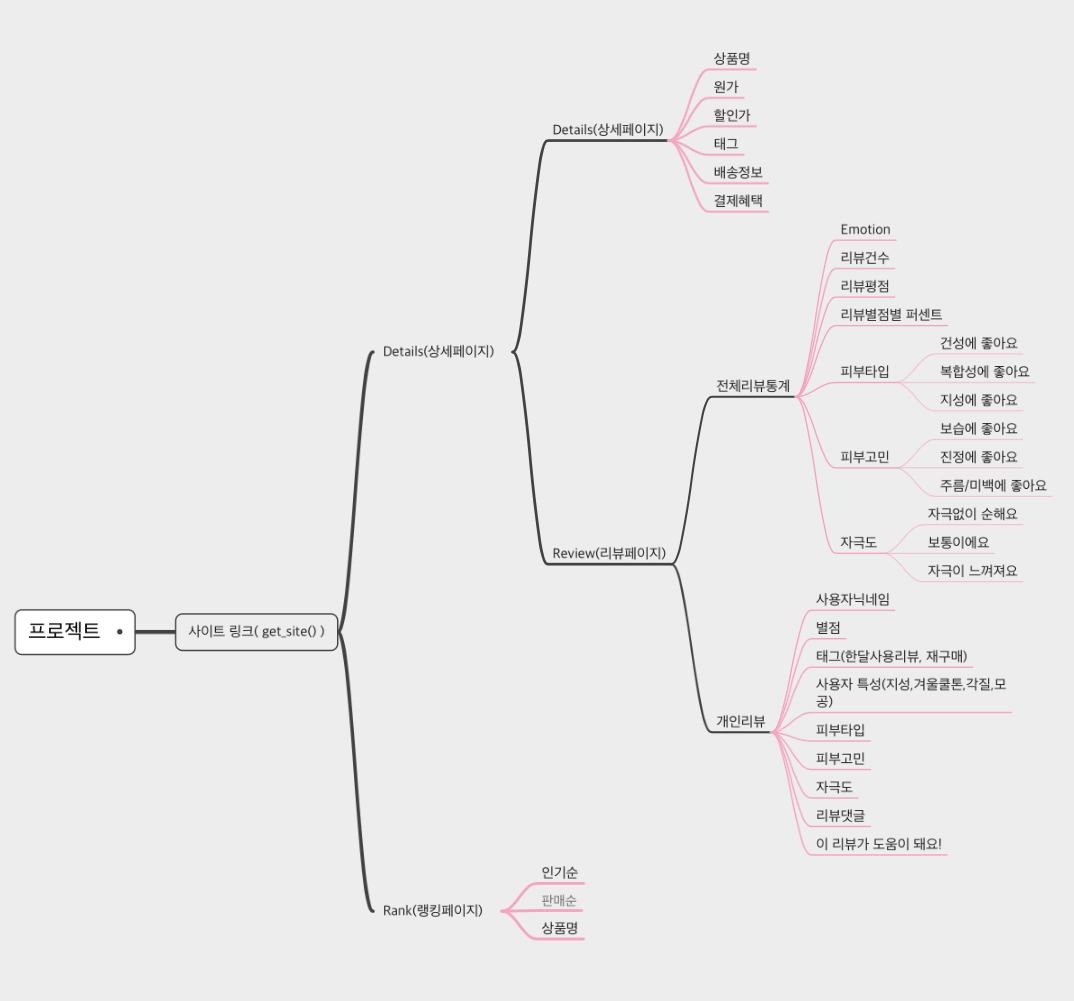

**각 순위별 데이터 수집 (인기순)**

In [ ]:
#Beatifulsoup
import requests
from bs4 import BeautifulSoup

# 상품 정보를 받을 리스트
prod_info_list = []

# 페이지 수 설정
num_pages = 15

# 각 페이지를 반복하여 데이터 수집
for page in range(1, num_pages + 1):

    url = get_link('인기순', page, 'rank')
    print(url)

    # requests를 사용하여 페이지 HTML 가져오기
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # CSS_SELECTOR를 활용해서 li 태그를 모두 가져오기
    lis = soup.select("li")

    # li들을 돌면서(각 상품을 돌면서)
    for li in lis:
        try:  # itemname 가져오기 시도하는데
            itemname = li.select_one("div.prd_name").text.strip()
        except:  # 실패할 경우
            continue  # 다음 루프로 넘어감

        # sale_price 가져오기
        sale_price = li.select_one("span.tx_cur").text.strip()
        try:
            # original_price 가져오기
            original_price = li.select_one("span.tx_org")
            original_price_text = original_price.text.strip() if original_price else ""
        except:
            original_price_text = ""

        # prod_info_list에 쌓기
        prod_info_list.append((itemname, sale_price, original_price_text))

print(prod_info_list)
print(len(prod_info_list))


https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010013&fltDispCatNo=&prdSort=01&pageIdx=1&rowsPerPage=24&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&trackingCd=Cat100000100010013_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%EC%8A%A4%ED%82%A8%2F%ED%86%A0%EB%84%88&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd=
https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010013&fltDispCatNo=&prdSort=01&pageIdx=2&rowsPerPage=24&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&trackingCd=Cat100000100010013_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%EC%8A%A4%ED%82%A8%2F%ED%86%A0%EB%84%88&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd=
https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010013&fltDispCatNo=&prdSort=01&pageIdx=3&rowsPerPage=24&searchTypeSort=btn_thumb&plusButtonFlag=N

In [ ]:
oliveyoung_df = pd.DataFrame(prod_info_list, columns = ['상품명', '판매가', '정가'])

oliveyoung_df

,상품명,판매가,정가
0,토리든[8월 올영픽/단독기획] 토리든 다이브인 저분자 히알루론산 토너 500ml 기...,"19,000원","29,000원"
1,헉슬리[수분부스터] 헉슬리 컨디셔닝 에센스 토너 프리쉐이프 300ml,"28,800원","36,000원"
2,아비브[쿨링진정] 아비브 어성초 카밍 토너 스킨부스터 더블 기획 (200ml+200ml),"27,300원","39,000원"
3,브링그린[8월 올영픽] 브링그린 티트리시카토너&크림기획(화장솜증정),"19,800원","34,200원"
4,라네즈[단독기획] 라네즈 크림스킨 170ml 기획 (+50ml),"26,400원","33,000원"
...,...,...,...
346,아비브[쿨링진정] 아비브 어성초 카밍 토너 스킨부스터 500ml 기획 (+화장솜 3...,"45,000원",
347,썸바이미썸바이미 아하 바하 파하 30 데이즈 미라클 토너기획(150ml+30ml),"21,600원",
348,에스트라에스트라 에이시카365 수분진정결토너 250ml 기획(+토너 50ml 증정),"25,500원","30,000원"
349,원씽원씽 인진쑥 추출물 토너 150ml,"9,900원",


In [ ]:
#홍서연 end
# 순위 열 추가 (1부터 시작)
oliveyoung_df['순위'] = range(1, len(oliveyoung_df) + 1)

# 열 순서 변경
oliveyoung_df = oliveyoung_df[['순위', '상품명', '판매가', '정가']]

# 결과 출력
oliveyoung_df

,순위,상품명,판매가,정가
0,1,토리든[8월 올영픽/단독기획] 토리든 다이브인 저분자 히알루론산 토너 500ml 기...,"19,000원","29,000원"
1,2,헉슬리[수분부스터] 헉슬리 컨디셔닝 에센스 토너 프리쉐이프 300ml,"28,800원","36,000원"
2,3,아비브[쿨링진정] 아비브 어성초 카밍 토너 스킨부스터 더블 기획 (200ml+200ml),"27,300원","39,000원"
3,4,브링그린[8월 올영픽] 브링그린 티트리시카토너&크림기획(화장솜증정),"19,800원","34,200원"
4,5,라네즈[단독기획] 라네즈 크림스킨 170ml 기획 (+50ml),"26,400원","33,000원"
...,...,...,...,...
346,347,아비브[쿨링진정] 아비브 어성초 카밍 토너 스킨부스터 500ml 기획 (+화장솜 3...,"45,000원",
347,348,썸바이미썸바이미 아하 바하 파하 30 데이즈 미라클 토너기획(150ml+30ml),"21,600원",
348,349,에스트라에스트라 에이시카365 수분진정결토너 250ml 기획(+토너 50ml 증정),"25,500원","30,000원"
349,350,원씽원씽 인진쑥 추출물 토너 150ml,"9,900원",


**각 순위별 데이터 수집 (판매순)**

In [ ]:
import requests
from bs4 import BeautifulSoup

# 크롤링할 페이지 수 설정
start_page = 1
end_page = 15

# 제품 정보를 저장할 리스트 초기화
prod_info_list = []

# 순위 변수 초기화
rank = 1

# 페이지 순회
for page in range(start_page, end_page + 1):
    url = get_link('판매순', page, 'rank')
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve page {page}")
        continue

    soup = BeautifulSoup(response.content, "html.parser")

    # 제품 정보를 담고 있는 li 태그들을 선택
    lis = soup.select("li")

    for li in lis:
        try:
            itemname = li.select_one("p.tx_name").text.strip()
        except:
            continue

        sale_price = li.select_one("span.tx_cur").text.strip() if li.select_one("span.tx_cur") else ""
        original_price = li.select_one("span.tx_org").text.strip() if li.select_one("span.tx_org") else ""

        # 순위 추가
        prod_info_list.append((rank, itemname, sale_price, original_price))
        rank += 1

    print(f"Page {page} scraped")

# 결과 출력
for prod in prod_info_list:
    print(prod)

print(len(prod_info_list))

Page 1 scraped
Page 2 scraped
Page 3 scraped
Page 4 scraped
Page 5 scraped
Page 6 scraped
Page 7 scraped
Page 8 scraped
Page 9 scraped
Page 10 scraped
Page 11 scraped
Page 12 scraped
Page 13 scraped
Page 14 scraped
Page 15 scraped
(1, '[8월 올영픽/단독기획] 토리든 다이브인 저분자 히알루론산 토너 500ml 기획 (+화장솜 60매 증정)', '19,000원', '29,000원')
(2, '[수분부스터] 헉슬리 컨디셔닝 에센스 토너 프리쉐이프 300ml', '28,800원', '36,000원')
(3, '[8월 올영픽] 브링그린 티트리시카토너&크림기획(화장솜증정)', '19,800원', '34,200원')
(4, '[쿨링진정] 아비브 어성초 카밍 토너 스킨부스터 더블 기획 (200ml+200ml)', '27,300원', '39,000원')
(5, '[8월올영픽/소윤PICK] 에스네이처 아쿠아 오아시스 토너 300ml 기획(+ 수분크림30ml증정)', '17,100원', '24,000원')
(6, '[수분진정] 이니스프리 그린티 히알루론산 스킨 170ml', '13,300원', '19,000원')
(7, '[단독기획] 라네즈 크림스킨 170ml 기획 (+50ml)', '26,400원', '33,000원')
(8, '[수딩진정] 넘버즈인 1번 진정 맑게담은 청초토너 300ml 기획 (+1번 패드 10매 증정)', '18,200원', '26,000원')
(9, '[속보습] 더랩바이블랑두 저분자 히알루론산 딥 토너 200ml + 50ml 기획', '15,990원', '23,000원')
(10, '[1등토너] 라운드랩 1025 독도 토너 200ml 기획 (+50ml 증정)', '15,000원', '')
(11, '[8월 올영픽/스누피키링증정]아누아 어성초 77 수딩 토너 500ml 스누

In [ ]:
oliveyoung_df = pd.DataFrame(prod_info_list, columns = ['순위', '상품명', '판매가', '정가',])

oliveyoung_df

,순위,상품명,판매가,정가
0,1,[8월 올영픽/단독기획] 토리든 다이브인 저분자 히알루론산 토너 500ml 기획 (...,"19,000원","29,000원"
1,2,[수분부스터] 헉슬리 컨디셔닝 에센스 토너 프리쉐이프 300ml,"28,800원","36,000원"
2,3,[8월 올영픽] 브링그린 티트리시카토너&크림기획(화장솜증정),"19,800원","34,200원"
3,4,[쿨링진정] 아비브 어성초 카밍 토너 스킨부스터 더블 기획 (200ml+200ml),"27,300원","39,000원"
4,5,[8월올영픽/소윤PICK] 에스네이처 아쿠아 오아시스 토너 300ml 기획(+ 수분...,"17,100원","24,000원"
...,...,...,...,...
346,347,[쿨링진정] 아비브 어성초 카밍 토너 스킨부스터 500ml 기획 (+화장솜 30매 증정),"45,000원",
347,348,썸바이미 아하 바하 파하 30 데이즈 미라클 토너기획(150ml+30ml),"21,600원",
348,349,에스트라 에이시카365 수분진정결토너 250ml 기획(+토너 50ml 증정),"25,500원","30,000원"
349,350,원씽 인진쑥 추출물 토너 150ml,"9,900원",


**상품별 상세 데이터 수집**

In [ ]:
#(상세)페이지 모으기
links = []
failed_links = []
links = []
page_max = 15 #최대 페이지 수  자동으로 알 수 있게 수정하기
sort_type = '인기순'  # 하나로 고정.
action = 'details'  # 접근하고 싶은 페이지

#병렬처리(코어수에 맞게)
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import cpu_count
from threading import Lock
from selenium.common.exceptions import TimeoutException

processed_count = 0
lock = Lock()

with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
    futures = {executor.submit(get_link, sort_type, page, action): page for page in range(0, page_max+1)}

    for future in as_completed(futures):
        link = futures[future]
        try:
            result = future.result()
            if result:
                with lock:
                    links.extend(result)
            else:
                print(f"Failed to scrape link (empty result): {link}")
                failed_links.extend(link)
        except Exception as e:
            print(f"An error occurred for link: {link}, error: {e}")
            failed_links.append(link)





# 중복을 제거한 링크를 새로운 리스트에 할당
links = list(set(links))

# 중복 제거 후의 총 링크 개수를 출력
print(f'{len(links)}개의 링크 수집 완료')

351개의 링크 수집 완료


In [ ]:
def get_cnt(text):
    # 평점 추출 (예: "평균 4.5점")
    rating_match = re.search(r'\d\.\d', text)
    rating = rating_match.group(0) if rating_match else '0.0'  # 달라졌음

    # 리뷰 개수 추출 (예: "12,099건")
    review_count_match = re.search(r'(\d{1,3}(,\d{3})*)건', text)
    review_count = review_count_match.group(1).replace(',', '') if review_count_match else '0'  # 달라졌음

    # # 디버깅 정보 출력
    # print(f"Rating match: {rating}")  # 달라졌음
    # print(f"Review count match: {review_count_match.group(0) if review_count_match else 'No match'}")  # 달라졌음

    return rating, review_count

In [ ]:
#BeautifulSoup 으로 크롤링
import requests
from bs4 import BeautifulSoup

def scrape_goods_info_BeautifulSoup(url):
    global processed_count

    try:
        # 페이지 HTML 가져오기
        response = requests.get(url)
        response.raise_for_status()  # HTTP 요청이 성공했는지 확인
        soup = BeautifulSoup(response.text, 'html.parser')

        # 데이터 추출
        brand = soup.select_one("p.prd_brand").text.strip()
        name = soup.select_one("p.prd_name").text.strip()

        # 요소가 존재할 때만 추출
        icon_flag_element = soup.select_one("p.prd_flag")
        icon_flag = icon_flag_element.text.strip() if icon_flag_element else None

        delivery_element = soup.select_one(".row")
        delivery = delivery_element.text.strip() if delivery_element else ""

        # 제거할 텍스트 목록
        remove_texts = [
            '배송정보배송정보 레이어 열기',
            '배송정보 안내 레이어열기',
            '픽업 안내 레이어열기'
        ]

        # 제거할 텍스트를 순차적으로 대체
        for text in remove_texts:
            delivery = delivery.replace(text, '')

        # 결제혜택
        benefit_elements = soup.select(".txt_list")
        benefits = [element.text.strip() for element in benefit_elements]

        remove_texts_benefits = [
            "카드혜택가 안내 레이어 열기",
            "CJ ONE 포인트 예상적립 레이어 열기"
        ]

        cleaned_benefits = []
        for benefit in benefits:
            original_benefit = benefit
            for text in remove_texts_benefits:
                benefit = benefit.replace(text, '')
            cleaned_benefit = benefit.strip()
            if cleaned_benefit:  # Cleaned benefits should not be empty
                cleaned_benefits.append(cleaned_benefit)
            else:
                # 빈 문자열 처리 및 디버깅
                print(f"Empty benefit after cleanup: {original_benefit}")

        # 별점과 리뷰 개수 추출
        star_num_review = soup.select_one("p#repReview").text.strip()
        lst = get_cnt(star_num_review)
        star_rating = lst[0]
        review_count = lst[1]

        # 수집한 데이터를 딕셔너리로 반환
        print(f"크롤링 완료 {processed_count}")
        processed_count += 1
        return {
            '브랜드': brand,
            '제품명': name,
            '아이콘': icon_flag,
            '배송정보': delivery,
            '결제혜택': ', '.join(cleaned_benefits),
            '별점': star_rating,
            '리뷰개수': review_count
        }

    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None


In [ ]:
#병렬처리(코어수에 맞게)
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import cpu_count
from threading import Lock
from selenium.common.exceptions import TimeoutException

lst_goods_info = []
failed_links = []
processed_count = 1
lock = Lock()

with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
    futures = {executor.submit(scrape_goods_info_BeautifulSoup, link): link for link in links}

    for future in as_completed(futures):
        link = futures[future]
        try:
            result = future.result()
            if result:
                with lock:
                    lst_goods_info.append(result)
            else:
                print(f"Failed to scrape link (empty result): {link}")
                failed_links.append(link)
        except TimeoutException as e:
            print(f"Timeout occurred for link: {link}, error: {e}")
            failed_links.append(link)
        except Exception as e:
            print(f"An error occurred for link: {link}, error: {e}")
            failed_links.append(link)

크롤링 완료 1
크롤링 완료 2
크롤링 완료 3
크롤링 완료 4
크롤링 완료 5
크롤링 완료 6
크롤링 완료 7
크롤링 완료 8
크롤링 완료 9
크롤링 완료 10
크롤링 완료 11
크롤링 완료 12
크롤링 완료 13
크롤링 완료 14
크롤링 완료 15
크롤링 완료 16
크롤링 완료 17
크롤링 완료 18
크롤링 완료 19
크롤링 완료 20
크롤링 완료 21
크롤링 완료 22
크롤링 완료 23
크롤링 완료 24
크롤링 완료 25
크롤링 완료 26
크롤링 완료 27
크롤링 완료 28
크롤링 완료 29
크롤링 완료 30
크롤링 완료 31
크롤링 완료 32
크롤링 완료 33
크롤링 완료 34크롤링 완료 34

크롤링 완료 36
크롤링 완료 37
크롤링 완료 38
크롤링 완료 39
크롤링 완료 40
크롤링 완료 41
크롤링 완료 42
크롤링 완료 43
크롤링 완료 44
크롤링 완료 45
크롤링 완료 46
크롤링 완료 47
크롤링 완료 48
크롤링 완료 49
크롤링 완료 50
크롤링 완료 51
크롤링 완료 52
크롤링 완료 53
크롤링 완료 54
크롤링 완료 55크롤링 완료 55

크롤링 완료 57
크롤링 완료 58
크롤링 완료 59크롤링 완료 59

크롤링 완료 61
크롤링 완료 62
크롤링 완료 63
크롤링 완료 64
크롤링 완료 65
크롤링 완료 66
크롤링 완료 67
크롤링 완료 68
크롤링 완료 69
크롤링 완료 70
크롤링 완료 71
크롤링 완료 72
크롤링 완료 73
크롤링 완료 74
크롤링 완료 75
크롤링 완료 76
크롤링 완료 77
크롤링 완료 78
크롤링 완료 79
크롤링 완료 80
크롤링 완료 81
크롤링 완료 82
크롤링 완료 83
크롤링 완료 84
크롤링 완료 85
크롤링 완료 86
크롤링 완료 87
크롤링 완료 88
크롤링 완료 89
크롤링 완료 90
크롤링 완료 91
크롤링 완료 92
크롤링 완료 93
크롤링 완료 94
크롤링 완료 95
크롤링 완료 96
크롤링 완료 97
크롤링 완료 98
크롤링 완료 99
크롤링 완료 100
크롤링 완료 1

In [ ]:
# 모든 작업 취소 후 기다리기
executor.shutdown(wait=True, cancel_futures=True)
print("All tasks have been cancelled and threads are stopped.")

All tasks have been cancelled and threads are stopped.


In [ ]:
failed_links

[]

In [ ]:
import tqdm

#실패한 링크 재시도
if(len(failed_links)):
  for link in tqdm(failed_links, desc="Scraping goods info"):
    result = scrape_goods_info_BeautifulSoup(link)
    if result:
      lst_goods_info.append(result)

In [ ]:
lst_goods_info = pd.DataFrame(lst_goods_info)

In [ ]:
#최종 데이터
display(lst_goods_info)

,브랜드,제품명,아이콘,배송정보,결제혜택,별점,리뷰개수
0,닥터자르트,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),증정\n오늘드림,\n\n\n일반배송\n\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,THE CJ 카드 추가 10%할인 \n\n\t\t\t\t\t\t\t\t\t\t\tC...,4.7,157
1,브링그린,브링그린 대나무히알루수분토너500mL_NEW,세일\n오늘드림,\n\n\n일반배송\n\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,THE CJ 카드 추가 10%할인 \n\n\t\t\t\t\t\t\t\t\t\t\tC...,4.8,2293
2,더랩바이블랑두,[속보습] 더랩바이블랑두 올리고 히알루론산 딥 토너 500ml 대용량 기획 (+10...,세일\n오늘드림,\n\n\n일반배송\n\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,THE CJ 카드 추가 10%할인 \n\n\t\t\t\t\t\t\t\t\t\t\tC...,4.9,1091
3,AHC,AHC 온리 포맨 토너 150ml,세일\n증정\n오늘드림,\n\n\n일반배송\n\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,THE CJ 카드 추가 10%할인 \n\n\t\t\t\t\t\t\t\t\t\t\tC...,4.7,78
4,이즈앤트리,이즈앤트리 히아루론산 토너 200ml,세일\n증정\n오늘드림,\n\n\n일반배송\n\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,THE CJ 카드 추가 10%할인 \n\n\t\t\t\t\t\t\t\t\t\t\tC...,4.7,1049
...,...,...,...,...,...,...,...
346,큐어,[증량기획] 김정문알로에 큐어 워터 젤리 토너 기획 세트 500ml+50ml,세일\n오늘드림,\n\n\n일반배송\n\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,THE CJ 카드 추가 10%할인 \n\n\t\t\t\t\t\t\t\t\t\t\tC...,4.8,415
347,하루하루원더,하루하루원더 블랙라이스 히알루로닉 토너150ml (쌀알패드50매 증정),None,\n\n\n일반배송\n\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,THE CJ 카드 추가 10%할인 \n\n\t\t\t\t\t\t\t\t\t\t\tC...,4.8,86
348,라포티셀,라포티셀 A.C. 데일리 카밍 필링 부스터 200ml,세일\n오늘드림,\n\n\n일반배송\n\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,THE CJ 카드 추가 10%할인 \n\n\t\t\t\t\t\t\t\t\t\t\tC...,4.9,396
349,브링그린,[8월 올영픽] 브링그린 티트리시카토너&크림기획(화장솜증정),세일\n쿠폰\n오늘드림,\n\n\n일반배송\n\n\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t...,THE CJ 카드 추가 10%할인 \n\n\t\t\t\t\t\t\t\t\t\t\tC...,4.8,4687


**상품별 리뷰 데이터 수집**

In [ ]:
# 컬럼 이름 리스트
columns = [
    '제품명','Emotion', '리뷰건수', '리뷰평점', '리뷰평점1점','리뷰평점2점','리뷰평점3점','리뷰평점4점','리뷰평점5점',
    '피부타입(건성에 좋아요)', '피부타입(복합성에 좋아요)', '피부타입(지성에 좋아요)',
    '피부고민(보습에 좋아요)', '피부고민(진정에 좋아요)', '피부고민(주름/미백에 좋아요)',
    '자극도(자극없이 순해요)', '자극도(보통이에요)', '자극도(자극이 느껴져요)','Link'
]


# 빈 데이터프레임 생성
total_review_df = pd.DataFrame(columns=columns)

# 컬럼 이름 리스트
columns = [
    '제품명', '사용자닉네임', '별점', '태그(한달사용리뷰, 재구매)',
    '사용자 특성(지성, 겨울쿨톤, 각질, 모공)', '피부타입',
    '피부고민', '자극도', '리뷰댓글', '이 댓글이 도움돼요!','Link'
]

# 빈 데이터프레임 생성
total_review_frames = pd.DataFrame(columns=columns)



In [ ]:
#기존의 csv의 파일을 확인하여 이미 등록된 데이터인지 확인(파일이 없다면 새로운 파일 생성)
if os.path.isfile('vectorDB_total_review_df.csv'):
    total_review_df = pd.read_csv('vectorDB_total_review_df.csv')
    total_review_frames = pd.read_csv('vectorDB_total_review_frames.csv')
    print("파일이 존재합니다.")
else:
    print("파일이 존재하지 않습니다. 새로운 파일을 생성합니다.")

#total_review_frames['Link'] 무슨 값이 있는지 출력 중복된것은 제외
crawled_links = total_review_frames['Link'].unique()

# 크롤링할 링크가 있는지 확인하고, 있으면 selected_links에 할당
if any(link not in crawled_links for link in links):
    selected_links = [link for link in links if link not in crawled_links]
    #selected_links 프린트
    display(selected_links)
    print(f"전체 {len(links)} 중 미등록 링크가 {len(selected_links)}개 있습니다.")
else:
    selected_links = []
    print("새로운 링크가 없습니다.")

파일이 존재하지 않습니다. 새로운 파일을 생성합니다.


['https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000128323',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000188048',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000147660',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000207054',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000129443',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000118427',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000199824',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000159263',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000190280',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000139057',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?goodsNo=A000000171614',
 'https://www.oliveyoung.co.kr/store/goods/getGoodsDetail.do?good

전체 351 중 미등록 링크가 351개 있습니다.


In [ ]:
#셀리니움을 이용한 리뷰크롤링
from logging import exception
import traceback

# 데이터 수집 함수 정의
def scrape_reviews(link):
    try:
      global failed_links
      global total_review_df
      global total_review_frames
      global processed_count
      # WebDriver 초기화
      driver = webdriver.Chrome(options=chrome_options)


      # 컬럼 이름 리스트
      columns = [
          '제품명','Emotion', '리뷰건수', '리뷰평점', '리뷰평점1점','리뷰평점2점','리뷰평점3점','리뷰평점4점','리뷰평점5점',
          '피부타입(건성에 좋아요)', '피부타입(복합성에 좋아요)', '피부타입(지성에 좋아요)',
          '피부고민(보습에 좋아요)', '피부고민(진정에 좋아요)', '피부고민(주름/미백에 좋아요)',
          '자극도(자극없이 순해요)', '자극도(보통이에요)', '자극도(자극이 느껴져요)','Link'
      ]
      local_review_df = pd.DataFrame(columns=columns)


      # 컬럼 이름 리스트
      columns = [
          '제품명', '사용자닉네임', '별점', '태그(한달사용리뷰, 재구매)',
          '사용자 특성(지성, 겨울쿨톤, 각질, 모공)', '피부타입',
          '피부고민', '자극도', '리뷰댓글', '이 댓글이 도움돼요!','Link'
      ]
      local_review_frames = pd.DataFrame(columns=columns)


      #상세페이지 접근
      driver.get(link)

      #페이지 로딩기다리기
      wait = WebDriverWait(driver, 30)
      wait.until(lambda driver: driver.execute_script('return document.readyState') == 'complete')

      #제품명 추가
      name = driver.find_element(By.CSS_SELECTOR, "p.prd_name").text

      # 리뷰 숫자 찾기
      element = driver.find_element(By.CSS_SELECTOR, '#reviewInfo > a > span')

      # 요소의 텍스트 가져오기
      text = element.text

      # 정규식을 사용하여 괄호 안의 숫자를 추출
      match = re.search(r'\((\d+)\)', text)

      # 숫자가 0인지 확인
      if match and int(match.group(1)) == 0:
          no_review = True
      else:
          no_review = False


      #원하는 버튼 클릭
      try:
          # 리뷰 버튼 클릭
          button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "a.goods_reputation")))
          button.click()
          # 페이지가 완전히 로드될 때까지 대기
          wait.until(lambda driver: driver.execute_script('return document.readyState') == 'complete')

          if no_review:
            # 리뷰가 비어있는 경우

            username = None
            rating = None
            tags = None
            user_characteristics = None
            skin_type = None
            skin_concerns = None
            irritation_level = None
            review_comment = None
            helpful_comment = None

            #나머진 다 None
            emotion = None
            review_count = None
            rating_5 = None
            rating_4 = None
            rating_3 = None
            rating_2 = None
            rating_1 = None
            skin_type_dry = None
            skin_type_combination = None
            skin_type_oily = None
            concern_moisture = None
            concern_soothing = None
            concern_wrinkle_whitening = None
            irritation_no = None
            irritation_moderate = None
            irritation_yes = None

            # 리뷰 데이터 사전
            review_data_1 = {
                '제품명': name,
                '사용자닉네임': username,
                '별점': rating,
                '태그(한달사용리뷰, 재구매)': tags,
                '사용자 특성(지성, 겨울쿨톤, 각질, 모공)': user_characteristics,
                '피부타입': skin_type,
                '피부고민': skin_concerns,
                '자극도': irritation_level,
                '리뷰댓글': review_comment,
                '이 댓글이 도움돼요!': helpful_comment,
                'Link' : link
            }

            # 수집한 데이터를 사전 형태로 저장
            review_data_2 = {
                '제품명': name,
                'Emotion': emotion,
                '리뷰건수': review_count,
                '리뷰평점': rating,
                '리뷰평점5점': rating_5,
                '리뷰평점4점': rating_4,
                '리뷰평점3점': rating_3,
                '리뷰평점2점': rating_2,
                '리뷰평점1점': rating_1,
                '피부타입(건성에 좋아요)': skin_type_dry,
                '피부타입(복합성에 좋아요)': skin_type_combination,
                '피부타입(지성에 좋아요)': skin_type_oily,
                '피부고민(보습에 좋아요)': concern_moisture,
                '피부고민(진정에 좋아요)': concern_soothing,
                '피부고민(주름/미백에 좋아요)': concern_wrinkle_whitening,
                '자극도(자극없이 순해요)': irritation_no,
                '자극도(보통이에요)': irritation_moderate,
                '자극도(자극이 느껴져요)': irritation_yes,
                'Link' : link
            }

            # 로컬 리뷰 데이터 프레임에 축적
            with lock:
              total_review_frames = pd.concat([total_review_frames, pd.DataFrame([review_data_1])], ignore_index=True)
              total_review_df = pd.concat([total_review_df, pd.DataFrame([review_data_2])], ignore_index=True)

            return 0

          # 리뷰가 있는경우
          else:
            pass


          wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#gdasContentsArea > div > div.product_rating_area.review-write-delete")))



          # 각 리뷰 요소에서 데이터를 추출
          # 리뷰통계 상단부분
          review_element = driver.find_element(By.CSS_SELECTOR, "#gdasContentsArea > div > div.product_rating_area.review-write-delete")


          emotion = review_element.find_element(By.CSS_SELECTOR, "p > em").text

          review_count = review_element.find_element(By.CSS_SELECTOR, "p.total > em").text

          rating = review_element.find_element(By.CSS_SELECTOR, "strong").text

          rating_5 = review_element.find_element(By.CSS_SELECTOR, "ul > li:nth-child(1) > span.per").text

          rating_4 = review_element.find_element(By.CSS_SELECTOR, "ul > li:nth-child(2) > span.per").text

          rating_3 = review_element.find_element(By.CSS_SELECTOR, "ul > li:nth-child(3) > span.per").text

          rating_2 = review_element.find_element(By.CSS_SELECTOR, "ul > li:nth-child(4) > span.per").text

          rating_1 = review_element.find_element(By.CSS_SELECTOR, "ul > li:nth-child(5) > span.per").text



          # 리뷰통계 하단부분
          try:
            review_element = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#gdasContentsArea > div > div.poll_all.clrfix")))
          except Exception as e:
            review_element = None



          skin_type_dry = review_element.find_element(By.CSS_SELECTOR, "div.poll_all.clrfix > dl:nth-child(1) > dd > ul > li:nth-child(1) > em").text if review_element else None
          skin_type_combination = review_element.find_element(By.CSS_SELECTOR, "div.poll_all.clrfix > dl:nth-child(1) > dd > ul > li:nth-child(2) > em").text if review_element else None
          skin_type_oily = review_element.find_element(By.CSS_SELECTOR, "div.poll_all.clrfix > dl:nth-child(1) > dd > ul > li:nth-child(3) > em").text if review_element else None

          concern_moisture = review_element.find_element(By.CSS_SELECTOR, "div.poll_all.clrfix > dl:nth-child(2) > dd > ul > li:nth-child(1) > em").text if review_element else None
          concern_soothing = review_element.find_element(By.CSS_SELECTOR, "div.poll_all.clrfix > dl:nth-child(2) > dd > ul > li:nth-child(2) > em").text if review_element else None
          concern_wrinkle_whitening = review_element.find_element(By.CSS_SELECTOR, "div.poll_all.clrfix > dl:nth-child(2) > dd > ul > li:nth-child(3) > em").text if review_element else None

          irritation_no = review_element.find_element(By.CSS_SELECTOR, "div.poll_all.clrfix > dl:nth-child(3) > dd > ul > li:nth-child(1) > em").text if review_element else None
          irritation_moderate = review_element.find_element(By.CSS_SELECTOR, "div.poll_all.clrfix > dl:nth-child(3) > dd > ul > li:nth-child(2) > em").text if review_element else None
          irritation_yes = review_element.find_element(By.CSS_SELECTOR, "div.poll_all.clrfix > dl:nth-child(3) > dd > ul > li:nth-child(3) > em").text if review_element else None



          # 수집한 데이터를 사전 형태로 저장
          review_data = {
              '제품명': name,
              'Emotion': emotion,
              '리뷰건수': review_count,
              '리뷰평점': rating,
              '리뷰평점5점': rating_5,
              '리뷰평점4점': rating_4,
              '리뷰평점3점': rating_3,
              '리뷰평점2점': rating_2,
              '리뷰평점1점': rating_1,
              '피부타입(건성에 좋아요)': skin_type_dry,
              '피부타입(복합성에 좋아요)': skin_type_combination,
              '피부타입(지성에 좋아요)': skin_type_oily,
              '피부고민(보습에 좋아요)': concern_moisture,
              '피부고민(진정에 좋아요)': concern_soothing,
              '피부고민(주름/미백에 좋아요)': concern_wrinkle_whitening,
              '자극도(자극없이 순해요)': irritation_no,
              '자극도(보통이에요)': irritation_moderate,
              '자극도(자극이 느껴져요)': irritation_yes,
              'Link' : link
          }

          #데이터
          local_review_df = pd.DataFrame([review_data])
          #기존 데이터 프레임에 축적
          with lock:
            total_review_df = pd.concat([total_review_df, pd.DataFrame([review_data])], ignore_index=True)




          for _ in range(crawling_review_page): # n페이지만
              try:
                #데이터 수집 및 추가


                # 페이지가 완전히 로드될 때까지 대기
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, '#gdasContentsArea > div > div.pageing')))


                review_element = driver.find_element(By.CSS_SELECTOR, "#gdasContentsArea > div > div.pageing")

                # 현재 페이지 번호
                button_element = review_element.find_element(By.CSS_SELECTOR, "[title='현재 페이지']")
                now_page = int(button_element.get_attribute('innerHTML').strip())


                #대기시간 주기
                time.sleep(1)

                # 페이지가 완전히 로드될 때까지 대기
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'span.num')))



                # 리뷰 리스트 불러오기
                inner_list = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "#gdasContentsArea > div > div.review_list_wrap")))
                review_elements = inner_list.find_elements(By.TAG_NAME, "li")
                # 사용자 이름이 있는것만 추출
                review_elements = [element for element in review_elements if element.find_elements(By.CSS_SELECTOR, "a.id")]




                # 각 review_element에서 데이터 추출
                for review_element in review_elements:
                    retry_count = 3
                    while retry_count > 0:
                      try:
                        # 요소가 존재할 때만 텍스트를 추출하는 코드
                        username = WebDriverWait(review_element, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "a.id"))).text if len(review_element.find_elements(By.CSS_SELECTOR, "a.id")) > 0 else None


                        rating = WebDriverWait(review_element, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "span.point"))).text if len(review_element.find_elements(By.CSS_SELECTOR, "span.point")) > 0 else None


                        tags = WebDriverWait(review_element, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.badge"))).text if len(review_element.find_elements(By.CSS_SELECTOR, "div.badge")) > 0 else None


                        user_characteristics = WebDriverWait(review_element, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "p.tag"))).text if len(review_element.find_elements(By.CSS_SELECTOR, "p.tag")) > 0 else None


                        skin_type = WebDriverWait(review_element, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "dl:nth-child(1) > dd > span"))).text if len(review_element.find_elements(By.CSS_SELECTOR, "dl:nth-child(1) > dd > span")) > 0 else None


                        skin_concerns = WebDriverWait(review_element, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "dl:nth-child(2) > dd > span"))).text if len(review_element.find_elements(By.CSS_SELECTOR, "dl:nth-child(2) > dd > span")) > 0 else None


                        irritation_level = WebDriverWait(review_element, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "dl:nth-child(3) > dd > span"))).text if len(review_element.find_elements(By.CSS_SELECTOR, "dl:nth-child(3) > dd > span")) > 0 else None


                        review_comment = WebDriverWait(review_element, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.txt_inner"))).text if len(review_element.find_elements(By.CSS_SELECTOR, "div.txt_inner")) > 0 else None


                        helpful_comment = WebDriverWait(review_element, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "span.num"))).text if len(review_element.find_elements(By.CSS_SELECTOR, "span.num")) > 0 else None




                        # 수집한 데이터를 사전 형태로 저장

                        # 리뷰 데이터 사전
                        review_data = {
                            '제품명': name,
                            '사용자닉네임': username,
                            '별점': rating,
                            '태그(한달사용리뷰, 재구매)': tags,
                            '사용자 특성(지성, 겨울쿨톤, 각질, 모공)': user_characteristics,
                            '피부타입': skin_type,
                            '피부고민': skin_concerns,
                            '자극도': irritation_level,
                            '리뷰댓글': review_comment,
                            '이 댓글이 도움돼요!': helpful_comment,
                            'Link' : link
                        }


                        # 로컬 리뷰 데이터 프레임에 축적
                        with lock:
                          local_review_frames = pd.concat([local_review_frames, pd.DataFrame([review_data])], ignore_index=True)
                        break
                      except exception as e:
                        retry_count -= 1
                        if retry_count == 0:
                            raise





                press_button= now_page + 1


                #만약 (10의 배수 + 1) 일 경우 '>>' 버튼을 누르고 진행
                if (press_button % 10) == 1:
                  try:
                    # 다음페이지 클릭 (CSS 선택자를 사용하여)
                    button = driver.find_element(By.CSS_SELECTOR, "#gdasContentsArea > div > div.pageing > a.next")
                    button.click()

                    time.sleep(0.7)

                  except Exception as e:

                    break
                else:
                    # 다음페이지 클릭 (CSS 선택자를 사용하여)
                    # 페이지가 완전히 로드될 때까지 대기
                    wait.until(EC.element_to_be_clickable((By.XPATH,  f"//a[text()='{press_button}']")))


                    # 버튼 누름
                    button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, f"//a[text()='{press_button}']")))
                    button.click()




              except Exception as e:
                # 더 이상 버튼을 찾을 수 없으면 루프 종료
                break

          # total_review_frames에 축적
          total_review_frames = pd.concat([total_review_frames, local_review_frames], ignore_index=True)
      except Exception as e:
        print(f"오류 발생: {e} : {link}")
        failed_links.append(link)
        traceback.print_exc()
        driver.quit()  # 드라이버 종료
        return 0
      finally:
        with lock:
          processed_count += 1
        print(f"처리된 링크 수: {processed_count}")
        driver.quit()  # 드라이버 종료
        return local_review_df, local_review_frames
    except Exception as e:
      print(f"처음 오류 발생: {e} : {link}")
      failed_links.append(link)
      traceback.print_exc()
      driver.quit()  # 드라이버 종료
      return 0



In [ ]:
#오류 확인용 단일처리
# for link in selected_links:
#   scrape_reviews(link)

In [ ]:
#병렬처리(코어수에 맞게)
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import cpu_count
from threading import Lock

processed_count = 0
lock = Lock()
failed_links = []

with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
    future_to_url = {executor.submit(scrape_reviews, url): url for url in selected_links}

처리된 링크 수: 1
처리된 링크 수: 2
처리된 링크 수: 3
처리된 링크 수: 4
처리된 링크 수: 5
처리된 링크 수: 6
처리된 링크 수: 7
처리된 링크 수: 8
처리된 링크 수: 9
처리된 링크 수: 10
처리된 링크 수: 11
처리된 링크 수: 12
처리된 링크 수: 13
처리된 링크 수: 14
처리된 링크 수: 15
처리된 링크 수: 16
처리된 링크 수: 17
처리된 링크 수: 18
처리된 링크 수: 19
처리된 링크 수: 20
처리된 링크 수: 21
처리된 링크 수: 22
처리된 링크 수: 23
처리된 링크 수: 24
처리된 링크 수: 25
처리된 링크 수: 26
처리된 링크 수: 27
처리된 링크 수: 28
처리된 링크 수: 29
처리된 링크 수: 30
처리된 링크 수: 31
처리된 링크 수: 32
처리된 링크 수: 33
처리된 링크 수: 34
처리된 링크 수: 35
처리된 링크 수: 36
처리된 링크 수: 37
처리된 링크 수: 38
처리된 링크 수: 39
처리된 링크 수: 40
처리된 링크 수: 41
처리된 링크 수: 42
처리된 링크 수: 43
처리된 링크 수: 44
처리된 링크 수: 45
처리된 링크 수: 46
처리된 링크 수: 47
처리된 링크 수: 48
처리된 링크 수: 49
처리된 링크 수: 50
처리된 링크 수: 51
처리된 링크 수: 52
처리된 링크 수: 53
처리된 링크 수: 54
처리된 링크 수: 55
처리된 링크 수: 56
처리된 링크 수: 57
처리된 링크 수: 58
처리된 링크 수: 59
처리된 링크 수: 60
처리된 링크 수: 61
처리된 링크 수: 62
처리된 링크 수: 63
처리된 링크 수: 64
처리된 링크 수: 65
처리된 링크 수: 66
처리된 링크 수: 67
처리된 링크 수: 68
처리된 링크 수: 69
처리된 링크 수: 70
처리된 링크 수: 71
처리된 링크 수: 72
처리된 링크 수: 73
처리된 링크 수: 74
처리된 링크 수: 75
처리된 링크 수: 76
처리된 링크 수: 77
처리된 링크 수

In [ ]:
# 모든 작업 취소 후 기다리기
executor.shutdown(wait=True, cancel_futures=True)
print("All tasks have been cancelled and threads are stopped.")

All tasks have been cancelled and threads are stopped.


In [ ]:
# 실패한 링크 재시도
processed_count = 0

while(failed_links):
  print(f"실패한 링크가 {len(failed_links)}개 있습니다.")
  for link in failed_links:
      scrape_reviews(link)
  # 성공적으로 작업이 완료된 링크를 failed_links에서 제외
  successful_links = set(total_review_df['Link'])
  failed_links = [link for link in failed_links if link not in successful_links]


In [ ]:
#실패한링크
#겹치는거 제거
failed_links = list(set(failed_links))
print(f"실패한 링크가 {len(failed_links)}개 있습니다.")
failed_links

실패한 링크가 0개 있습니다.


[]

크롤링 시간을 줄이기위해
1. try 문의 최소화 if 문 대체
2. 병렬처리로 사이트 접속시간 최소화


In [ ]:
#중복 데이터는 삭제
#제품명이 같으면 중복처리
total_review_df = total_review_df.drop_duplicates(subset=['제품명'])
#제품명과 리뷰댓글이 같으면 중복처리
total_review_frames = total_review_frames.drop_duplicates(subset=['제품명', '리뷰댓글'])

In [ ]:
display(total_review_df)
display(total_review_frames)

,제품명,Emotion,리뷰건수,리뷰평점,리뷰평점1점,리뷰평점2점,리뷰평점3점,리뷰평점4점,리뷰평점5점,피부타입(건성에 좋아요),피부타입(복합성에 좋아요),피부타입(지성에 좋아요),피부고민(보습에 좋아요),피부고민(진정에 좋아요),피부고민(주름/미백에 좋아요),자극도(자극없이 순해요),자극도(보통이에요),자극도(자극이 느껴져요),Link
0,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),최고,157,4.7,1%,0%,4%,16%,80%,7%,59%,34%,8%,92%,1%,50%,38%,12%,https://www.oliveyoung.co.kr/store/goods/getGo...
1,브링그린 대나무히알루수분토너500mL_NEW,최고,"2,293",4.8,0%,0%,3%,14%,83%,28%,54%,18%,54%,46%,1%,77%,23%,1%,https://www.oliveyoung.co.kr/store/goods/getGo...
2,AHC 온리 포맨 토너 150ml,최고,78,4.7,0%,1%,3%,17%,79%,27%,68%,5%,64%,33%,3%,55%,45%,0%,https://www.oliveyoung.co.kr/store/goods/getGo...
3,[속보습] 더랩바이블랑두 올리고 히알루론산 딥 토너 500ml 대용량 기획 (+10...,최고,"1,091",4.9,0%,0%,1%,6%,92%,67%,0%,33%,67%,33%,0%,100%,0%,0%,https://www.oliveyoung.co.kr/store/goods/getGo...
4,이즈앤트리 히아루론산 토너 200ml,최고,"1,049",4.7,0%,1%,5%,15%,79%,43%,47%,10%,74%,26%,1%,80%,18%,2%,https://www.oliveyoung.co.kr/store/goods/getGo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,하루하루원더 블랙라이스 히알루로닉 토너150ml (쌀알패드50매 증정),최고,86,4.8,0%,0%,1%,22%,77%,44%,49%,7%,73%,27%,1%,85%,15%,0%,https://www.oliveyoung.co.kr/store/goods/getGo...
347,[증량기획] 김정문알로에 큐어 워터 젤리 토너 기획 세트 500ml+50ml,최고,415,4.8,1%,0%,3%,12%,84%,23%,61%,16%,39%,61%,1%,75%,25%,1%,https://www.oliveyoung.co.kr/store/goods/getGo...
348,라포티셀 A.C. 데일리 카밍 필링 부스터 200ml,최고,396,4.9,0%,0%,2%,6%,92%,19%,55%,26%,23%,69%,8%,65%,28%,7%,https://www.oliveyoung.co.kr/store/goods/getGo...
349,[8월 올영픽] 브링그린 티트리시카토너&크림기획(화장솜증정),최고,"4,687",4.8,0%,0%,3%,10%,86%,15%,56%,30%,19%,81%,0%,48%,41%,11%,https://www.oliveyoung.co.kr/store/goods/getGo...


,제품명,사용자닉네임,별점,"태그(한달사용리뷰, 재구매)","사용자 특성(지성, 겨울쿨톤, 각질, 모공)",피부타입,피부고민,자극도,리뷰댓글,이 댓글이 도움돼요!,Link
0,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),멀대,5점만점에 5점,한달이상사용,복합성 웜톤 탄력,지성에 좋아요,진정에 좋아요,자극없이 순해요,자극없고 피부진정에좋아 꾸준히 계속 사용하는 제품입니다,0,https://www.oliveyoung.co.kr/store/goods/getGo...
1,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),젤리스타,5점만점에 5점,,민감성 쿨톤 모공 민감성,복합성에 좋아요,보습에 좋아요,보통이에요,구매계기\n올영세일때 100원으로 구매해본후 너무 잘맞아서 정착,3,https://www.oliveyoung.co.kr/store/goods/getGo...
2,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),무이네에,5점만점에 5점,재구매,복합성 가을웜톤 트러블,복합성에 좋아요,진정에 좋아요,자극없이 순해요,예전부터 꾸준히 사용하던 제품인데 트러블 발생이 덜하게 되었습니다!,0,https://www.oliveyoung.co.kr/store/goods/getGo...
3,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),멀대,5점만점에 5점,,복합성 웜톤 탄력,지성에 좋아요,진정에 좋아요,자극없이 순해요,자극없이 순하고 보습력좋고 흡수력도 좋고 끈적임없이 좋습니다~~,0,https://www.oliveyoung.co.kr/store/goods/getGo...
4,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),굼미굼미,5점만점에 5점,,지성 웜톤 각질 모공,지성에 좋아요,진정에 좋아요,자극없이 순해요,지속적으로 사용하던 토너를 다 써가서 이번엔 새로운 제품을 사용해보려고 구매했어요~...,2,https://www.oliveyoung.co.kr/store/goods/getGo...
...,...,...,...,...,...,...,...,...,...,...,...
6434,[파워퍼프걸 굿즈] 파티온 노스카나인 트러블 클리어 토너 200ml 기획(+스팟패치...,우리집댕댕이뚱이,5점만점에 5점,재구매 한달이상사용,지성 쿨톤 모공 민감성,복합성에 좋아요,보습에 좋아요,자극없이 순해요,열통이 뭐야 스무통은 넘게쓰는듯 쟁여두고 쓸정도로 여드름에 너무죻아,0,https://www.oliveyoung.co.kr/store/goods/getGo...
6435,[파워퍼프걸 굿즈] 파티온 노스카나인 트러블 클리어 토너 200ml 기획(+스팟패치...,탱희,5점만점에 5점,,민감성 쿨톤 각질 모공,복합성에 좋아요,진정에 좋아요,보통이에요,남자친구 여드름 진정 때문에 사줬어요 ! 효과가 있으면 좋겠어요,0,https://www.oliveyoung.co.kr/store/goods/getGo...
6436,[파워퍼프걸 굿즈] 파티온 노스카나인 트러블 클리어 토너 200ml 기획(+스팟패치...,하우잉,5점만점에 3점,,트러블성 쿨톤 트러블,지성에 좋아요,진정에 좋아요,보통이에요,여드름의 피지 분비를 막고자 하였는데 모든 면에서 보통인 제품입니다.,0,https://www.oliveyoung.co.kr/store/goods/getGo...
6437,[파워퍼프걸 굿즈] 파티온 노스카나인 트러블 클리어 토너 200ml 기획(+스팟패치...,평생소원순두부,5점만점에 5점,재구매,복합성 봄웜톤 민감성,건성에 좋아요,보습에 좋아요,자극없이 순해요,파티온 라인으로 토너 앰플 크림 전부 바꿨어요 여드름성 피부에 좋은것 같아요,0,https://www.oliveyoung.co.kr/store/goods/getGo...


In [ ]:
#있다면 기존의 total_review_df.csv , exel 및 total_review_frames.csv, exel 불러오기
if os.path.exists('total_review_df.csv') and os.path.exists('total_review_frames.csv'):
  Existing_total_review_df = pd.read_csv('total_review_df.csv')
  Existing_total_review_frames = pd.read_csv('total_review_frames.csv')

  #데이터 축적하기
  total_review_df = pd.concat([Existing_total_review_df, total_review_df], ignore_index=True)
  total_review_frames = pd.concat([Existing_total_review_frames, total_review_frames], ignore_index=True)

#중복 데이터는 삭제
#제품명이 같으면 중복처리
total_review_df = total_review_df.drop_duplicates(subset=['제품명'])
#제품명과 리뷰댓글이 같으면 중복처리
total_review_frames = total_review_frames.drop_duplicates(subset=['제품명', '리뷰댓글'])

In [ ]:
display(total_review_df)
display(total_review_frames)

,제품명,Emotion,리뷰건수,리뷰평점,리뷰평점1점,리뷰평점2점,리뷰평점3점,리뷰평점4점,리뷰평점5점,피부타입(건성에 좋아요),피부타입(복합성에 좋아요),피부타입(지성에 좋아요),피부고민(보습에 좋아요),피부고민(진정에 좋아요),피부고민(주름/미백에 좋아요),자극도(자극없이 순해요),자극도(보통이에요),자극도(자극이 느껴져요),Link
0,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),최고,157,4.7,1%,0%,4%,16%,80%,7%,59%,34%,8%,92%,1%,50%,38%,12%,https://www.oliveyoung.co.kr/store/goods/getGo...
1,브링그린 대나무히알루수분토너500mL_NEW,최고,"2,293",4.8,0%,0%,3%,14%,83%,28%,54%,18%,54%,46%,1%,77%,23%,1%,https://www.oliveyoung.co.kr/store/goods/getGo...
2,AHC 온리 포맨 토너 150ml,최고,78,4.7,0%,1%,3%,17%,79%,27%,68%,5%,64%,33%,3%,55%,45%,0%,https://www.oliveyoung.co.kr/store/goods/getGo...
3,[속보습] 더랩바이블랑두 올리고 히알루론산 딥 토너 500ml 대용량 기획 (+10...,최고,"1,091",4.9,0%,0%,1%,6%,92%,67%,0%,33%,67%,33%,0%,100%,0%,0%,https://www.oliveyoung.co.kr/store/goods/getGo...
4,이즈앤트리 히아루론산 토너 200ml,최고,"1,049",4.7,0%,1%,5%,15%,79%,43%,47%,10%,74%,26%,1%,80%,18%,2%,https://www.oliveyoung.co.kr/store/goods/getGo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,하루하루원더 블랙라이스 히알루로닉 토너150ml (쌀알패드50매 증정),최고,86,4.8,0%,0%,1%,22%,77%,44%,49%,7%,73%,27%,1%,85%,15%,0%,https://www.oliveyoung.co.kr/store/goods/getGo...
347,[증량기획] 김정문알로에 큐어 워터 젤리 토너 기획 세트 500ml+50ml,최고,415,4.8,1%,0%,3%,12%,84%,23%,61%,16%,39%,61%,1%,75%,25%,1%,https://www.oliveyoung.co.kr/store/goods/getGo...
348,라포티셀 A.C. 데일리 카밍 필링 부스터 200ml,최고,396,4.9,0%,0%,2%,6%,92%,19%,55%,26%,23%,69%,8%,65%,28%,7%,https://www.oliveyoung.co.kr/store/goods/getGo...
349,[8월 올영픽] 브링그린 티트리시카토너&크림기획(화장솜증정),최고,"4,687",4.8,0%,0%,3%,10%,86%,15%,56%,30%,19%,81%,0%,48%,41%,11%,https://www.oliveyoung.co.kr/store/goods/getGo...


,제품명,사용자닉네임,별점,"태그(한달사용리뷰, 재구매)","사용자 특성(지성, 겨울쿨톤, 각질, 모공)",피부타입,피부고민,자극도,리뷰댓글,이 댓글이 도움돼요!,Link
0,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),멀대,5점만점에 5점,한달이상사용,복합성 웜톤 탄력,지성에 좋아요,진정에 좋아요,자극없이 순해요,자극없고 피부진정에좋아 꾸준히 계속 사용하는 제품입니다,0,https://www.oliveyoung.co.kr/store/goods/getGo...
1,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),젤리스타,5점만점에 5점,,민감성 쿨톤 모공 민감성,복합성에 좋아요,보습에 좋아요,보통이에요,구매계기\n올영세일때 100원으로 구매해본후 너무 잘맞아서 정착,3,https://www.oliveyoung.co.kr/store/goods/getGo...
2,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),무이네에,5점만점에 5점,재구매,복합성 가을웜톤 트러블,복합성에 좋아요,진정에 좋아요,자극없이 순해요,예전부터 꾸준히 사용하던 제품인데 트러블 발생이 덜하게 되었습니다!,0,https://www.oliveyoung.co.kr/store/goods/getGo...
3,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),멀대,5점만점에 5점,,복합성 웜톤 탄력,지성에 좋아요,진정에 좋아요,자극없이 순해요,자극없이 순하고 보습력좋고 흡수력도 좋고 끈적임없이 좋습니다~~,0,https://www.oliveyoung.co.kr/store/goods/getGo...
4,닥터자르트 컨트롤에이 티트리먼트 토너 200ml (티트리 약산성 토너),굼미굼미,5점만점에 5점,,지성 웜톤 각질 모공,지성에 좋아요,진정에 좋아요,자극없이 순해요,지속적으로 사용하던 토너를 다 써가서 이번엔 새로운 제품을 사용해보려고 구매했어요~...,2,https://www.oliveyoung.co.kr/store/goods/getGo...
...,...,...,...,...,...,...,...,...,...,...,...
6434,[파워퍼프걸 굿즈] 파티온 노스카나인 트러블 클리어 토너 200ml 기획(+스팟패치...,우리집댕댕이뚱이,5점만점에 5점,재구매 한달이상사용,지성 쿨톤 모공 민감성,복합성에 좋아요,보습에 좋아요,자극없이 순해요,열통이 뭐야 스무통은 넘게쓰는듯 쟁여두고 쓸정도로 여드름에 너무죻아,0,https://www.oliveyoung.co.kr/store/goods/getGo...
6435,[파워퍼프걸 굿즈] 파티온 노스카나인 트러블 클리어 토너 200ml 기획(+스팟패치...,탱희,5점만점에 5점,,민감성 쿨톤 각질 모공,복합성에 좋아요,진정에 좋아요,보통이에요,남자친구 여드름 진정 때문에 사줬어요 ! 효과가 있으면 좋겠어요,0,https://www.oliveyoung.co.kr/store/goods/getGo...
6436,[파워퍼프걸 굿즈] 파티온 노스카나인 트러블 클리어 토너 200ml 기획(+스팟패치...,하우잉,5점만점에 3점,,트러블성 쿨톤 트러블,지성에 좋아요,진정에 좋아요,보통이에요,여드름의 피지 분비를 막고자 하였는데 모든 면에서 보통인 제품입니다.,0,https://www.oliveyoung.co.kr/store/goods/getGo...
6437,[파워퍼프걸 굿즈] 파티온 노스카나인 트러블 클리어 토너 200ml 기획(+스팟패치...,평생소원순두부,5점만점에 5점,재구매,복합성 봄웜톤 민감성,건성에 좋아요,보습에 좋아요,자극없이 순해요,파티온 라인으로 토너 앰플 크림 전부 바꿨어요 여드름성 피부에 좋은것 같아요,0,https://www.oliveyoung.co.kr/store/goods/getGo...


In [ ]:
#csv로 저장
total_review_df.to_csv('total_review_df.csv', index=False)
total_review_frames.to_csv('total_review_frames.csv', index=False)

#**전처리 및 정규화**

##데이터 전처리

크롤링완료된 데이터 불러오기

In [ ]:
review_data = pd.read_csv('total_review_df.csv')
review_dataframes = pd.read_csv('total_review_frames.csv')

리뷰데이터 전처리

나머지데이터 전처리

##데이터 정규화

목표:
기계가 이해하기 쉬운 질문은 명확하고 구조화된 형식을 가지고 있으며, 불필요한 중복이나 모호성이 제거된 형태를 말합니다.

데이터 변환(정규화)

#**질문의 의도 파악(TF-IDF)**

목표:
기계가 이해하기 쉬운 질문은 명확하고 구조화된 형식을 가지고 있으며, 불필요한 중복이나 모호성이 제거된 형태를 말합니다.

쿼리 정규화

In [ ]:
def question(question)

  return question

SyntaxError: expected ':' (<ipython-input-37-0d3b30ba59ee>, line 1)

#**유사도 측정**

##Sentence transformer 적용

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# 리뷰데이터 불러오기

reviews = review_dataframes['리뷰댓글'].tolist()

In [ ]:
reviews

리뷰 임베딩 및 유사도 계산

In [ ]:
# 모델 로드
model = SentenceTransformer('bespin-global/klue-sroberta-base-continue-learning-by-mnr')


# 문장 임베딩 생성
embeddings = model.encode(reviews)

# 코사인 유사도 계산
cosine_similarities = cosine_similarity(embeddings)

# 결과를 데이터프레임으로 변환
df = pd.DataFrame(cosine_similarities, index=reviews, columns=reviews)

df

In [ ]:
# 각 컬럼에 대해 상위 3개 값을 출력하는 함수 정의
def print_top3_similarities(df):
    for column in df.columns:
        print(f"\n문장: {column}")
        top3 = df[column].nlargest(4).iloc[1:4]  # 자신과의 유사도가 1이기 때문에 제외
        for idx, value in top3.items():
            print(f"유사한 문장: {idx} (유사도: {value:.4f})")

# 상위 3개 유사도 출력
print_top3_similarities(df)

문장 유사도를 판단하는 기준은 응용 분야와 문맥에 따라 다르지만, 일반적으로 다음과 같은 코사인 유사도 기준을 참고할 수 있습니다:


0.9 이상: 매우 유사한 문장. 거의 같은 의미를 지니는 문장.

0.8 ~ 0.9: 유사한 문장. 같은 주제를 다루거나 비슷한 의미를 지니는 문장.

0.7 ~ 0.8: 어느 정도 유사한 문장. 문맥상 관련이 있는 문장.

0.6 ~ 0.7: 약간 유사한 문장. 완전히 다른 내용은 아니지만, 뚜렷한 차이가 있는 문장.

0.6 미만: 유사하지 않은 문장. 다른 의미를 지니는 문장.


이 기준은 상황에 따라 다를 수 있으며, 특정 응용 프로그램에서는 다르게 설정할 수도 있습니다. 예를 들어, 텍스트 검색 시스템에서는 0.8 이상의 유사도를 유사한 문장으로 볼 수 있지만, 대화형 AI에서는 0.7 이상의 유사도를 사용할 수 있습니다.

In [ ]:
def find_similar_reviews(question, reviews, threshold=0.7):
    # 질문과 리뷰 문장들 임베딩 생성
    question_embedding = model.encode([question])
    review_embeddings = model.encode(reviews)

    # 유사도 계산
    similarities = cosine_similarity(question_embedding, review_embeddings)[0]

    # 유사도가 threshold 이상인 리뷰 문장 선택
    similar_reviews = [reviews[i] for i in range(len(reviews)) if similarities[i] >= threshold]
    similar_scores = [similarities[i] for i in range(len(reviews)) if similarities[i] >= threshold]

    return similar_reviews, similar_scores


#**semetic search 프론트 엔드**

In [ ]:
# 코랩에서 필요한 라이브러리 설치 (한번만 실행)
!pip install sentence-transformers
!pip install scikit-learn
!pip install gradio

# Gradio 애플리케이션 코드 작성 및 실행
import gradio as gr
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#Semetic Search 함수

def find_similar_reviews(question):
    # 질문과 리뷰 문장들 임베딩 생성
    question_embedding = model.encode([question])
    review_embeddings = model.encode(reviews)

    # 유사도 계산
    similarities = cosine_similarity(question_embedding, review_embeddings)[0]

    # 유사도가 0.2 이상인 리뷰 문장 선택
    threshold = 0.2
    similar_reviews = [(reviews[i], similarities[i]) for i in range(len(reviews)) if similarities[i] >= threshold]

    if similar_reviews:
        similar_reviews.sort(key=lambda x: x[1], reverse=True)

        # 유사한 리뷰와 유사도 및 해당하는 제품명을 찾기
        result_data = []
        for review, score in similar_reviews:
            review_name = review_data[review_data['리뷰댓글'] == review]['제품명'].values
            if review_name.size > 0:
                result_data.append((review_name[0], review, score))

        # DataFrame 생성
        result_df = pd.DataFrame(result_data, columns=['제품명', '리뷰댓글', '유사도'])

        # DataFrame을 텍스트 형태로 변환하여 출력
        print("유사한 리뷰를 찾았습니다. 결과를 표로 표시합니다:")
        print(result_df.to_string(index=False))

        return result_df
    else:
        return "유사한 리뷰 문장을 찾을 수 없습니다."

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def fetch_image_from_url(url, driver_path):
    # URL로 이동
    driver.get(url)

    try:
        # CSS 선택자 #mainImg를 사용하여 이미지 찾기
        img_element = driver.find_element(By.CSS_SELECTOR, '#mainImg')
        img_url = img_element.get_attribute('src')

        # 이미지 다운로드
        img_response = requests.get(img_url)
        if img_response.status_code == 200:
            img = Image.open(BytesIO(img_response.content))
            driver.quit()
            return img
        else:
            print("이미지를 다운로드하는데 실패했습니다.")
            driver.quit()
            return None
    except Exception as e:
        print(f"이미지를 찾는 도중 에러가 발생했습니다: {e}")
        driver.quit()
        return None

In [ ]:
def find_similar_reviews(question):
    try:
        # 질문과 리뷰 문장들 임베딩 생성
        question_embedding = model.encode([question])
        review_embeddings = model.encode(reviews)

        # 유사도 계산
        similarities = cosine_similarity(question_embedding, review_embeddings)[0]

        # 유사도가 0.2 이상인 리뷰 문장 선택
        threshold = 0.2
        similar_reviews = [(reviews[i], similarities[i]) for i in range(len(reviews)) if similarities[i] >= threshold]

        if similar_reviews:
            similar_reviews.sort(key=lambda x: x[1], reverse=True)

            # 유사한 리뷰와 유사도 및 해당하는 제품명을 찾기
            result_data = []
            for review, score in similar_reviews:
                matching_rows = review_data[review_data['리뷰댓글'] == review]
                if not matching_rows.empty:
                    review_name = matching_rows.iloc[0]['제품명']
                    result_data.append((review_name, review, score))

            # DataFrame 생성
            result_df = pd.DataFrame(result_data, columns=['제품명', '리뷰댓글', '유사도'])

            # DataFrame을 HTML 형태로 변환하여 출력
            return result_df.to_html(index=False)
        else:
            return "유사한 리뷰 문장을 찾을 수 없습니다."
    except Exception as e:
        return f"오류 발생: {str(e)}"

In [ ]:
with gr.Blocks() as iface:
    gr.Markdown(
        """
        <style>
            body { background-color: #121212; color: white; }
            .gradio-container { background-color: #121212; color: white; }
            .gr-button { background-color: #6200ea; color: white; }
            .gr-textbox { background-color: #1f1f1f; color: white; }
            .logo-container { display: flex; justify-content: center; }
        </style>
        """
    )
    gr.Markdown("# 올리브영 스킨/토너 추천검색")

    # 로고 중앙 정렬을 위한 컨테이너
    with gr.Row():
        with gr.Column():
            gr.Markdown(
              """
              <style>
                  body { background-color: #121212; color: white; }
                  .gradio-container { background-color: #121212; color: white; }
                  .gr-button { background-color: #6200ea; color: white; }
                  .gr-textbox { background-color: #1f1f1f; color: white; }
                  .logo-container { text-align: center; }
              </style>
              """
            )
            gr.Markdown(
                """
                <div class="logo-container">
                    <img src="https://image.oliveyoung.co.kr/pc-static-root/image/comm/h1_logo.png" alt="OliveYoung Logo" style="width: 200px; height: 50px;">
                </div>
                """
            )

    gr.Markdown("""
    #### 스킨케어 제품 추천을 원하시나요? 질문을 입력하시면 올리브영에서 가장 적합한 제품을 찾아드립니다!
    """)

    question = gr.Textbox(label="질문", lines=2, placeholder="질문을 입력하세요...", max_lines=3)

    find_button = gr.Button("유사한 리뷰 찾기")
    output = gr.HTML(label="유사한 리뷰 문장들")

    find_button.click(fn=question, inputs=question, outputs=output)


In [ ]:
# 애플리케이션 실행
iface.launch()